In [1]:
import fastf1 as f1
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector

In [2]:
tf = pd.DataFrame(columns = ["A", "B", "C"])
tf.A = [1, 2, 3]
tf.B = [4, 5, 6]
tf.C = [7, 8, 9]
tf = tf.set_index(["A", "B"])
#tf["D"] = tf.index.to_series()
#2 * tf  # Index not affected
#tf.mean()
tf + tf.shift()

,,C
A,B,
1,4,NaN
2,5,15.0
3,6,17.0


In [3]:
tf.index.get_level_values("A").to_series()

A
1    1
2    2
3    3
Name: A, dtype: int64

Note: Number of laps in current format only works with race because teams can refuel during practice/quali!

# Formula 1 Performance Analysis Introduction
In order to perform well in a Formula 1 Grand Prix race, teams must develop a successful strategy for determining what compounds of tires to use during the race (there are several types of tires, each of which have a different tradeoff in terms of grip and lifespan), and when to make a pit stop to swap to a new pair of tires. While this is a very complex problem involving many variables, one of the most important things to consider is how long a set of tires will last before they lose enough grip to justify making a pit stop and changing the tires. One of the simpleset ways to measure vehicle performance is by using the lap times the car is capable of.


This project aims to model vehicle lap times around a circuit, using publicly available features such as:
* Number of laps driven during the session
* Tire age in laps driven
* Number of laps driven at a slower pace (eg, slowdown required for safety reasons)
* Weather data (eg, track and air temperatures, humidity pressure)
* Distance to car ahead (which impacts the vehicle's aerodynamics)
* Driver's best lap time
* Whether the car has made a pit stop on this lap


For the sake of scope, this project will focus on only one event: the 2025 Japanese Grand Prix, which I have chosen because of its lack of rain and race interuptions in order to make data cleaning and analysis simpler. In the future, the techniques applied here could be used on other events, and with the right features, a model could accurately predict lap times from multiple circuits.

If this project is sufficiently successful, the results could be used for predictive analytics and could assist the development of a "virtual race engineer," or a machine learning model that can make real time decisions in regards to actions such as pit stops in order to complete a race as quickly as possible. Additionally, understanding how different tire compounds perform on a given race track can improve future decisions on which tire types to use in future Grand Prix events.

## ETL
The best source I found for this project is FastF1, a python package/data warehouse that curates data from Formula 1 official live timings (I came across this framework when I was browsing F1 related data sets on kaggle and saw FastF1 as a source for some of them). Each track session is separated into its own session object, which can be retrieved individually via the FastF1 package:

In [4]:
# This function ended up going unused in this version of the project due to running out of time to make it work. I have only left it in so I can work on it in the future
def get_average_values(df, lower_bound, upper_bound):  # Should this be refactored to take in series instead?
    """
    Given a dataframe with index Time and lower and upper time bounds (of type timestamp) and solely containing numeric data,
    returns the weighted average over time (assuming change in these values over time is linear)
    of all columns in the dataframe in the form of a Series.
    """
    
    df = df.assign(TimeInSeconds = df.index.to_series().dt.total_seconds())  # Change time format to total seconds to make division possible
    
    frame_in_range = df[(df.index <= upper_bound) & (df.index >= lower_bound)].sort_index(level = "Time")
    #print(f"frame_in_range:\n{frame_in_range}")
    # TODO: Refactor so these value rows default to series, then convert to dataframe as needed?
    t0_values = df[df.index <= lower_bound].sort_index(level = "Time").iloc[-1:]  # Last value recorded before lower_bound
    t1_values = frame_in_range.iloc[:1]  # First value inside range
    
    tpen_values = frame_in_range.iloc[-1:]  # Last value inside range, ie t_penultimate
    tmax_values = df[df.index >= upper_bound].sort_index(level = "Time").iloc[:1]  # First value recorded afer upper_bound
    #print(f"t0:\n{t0_values}\nt1:\n{t1_values}\ntpen:\n{tpen_values}\ntmax:\n{tmax_values}")
    
    # Assign estimate values to boundaries and add them to frame_in_range
    theta = lambda t, t0, t1: np.divide(t - t0, t1 - t0)  # t is one of bounds, t0 and t1 are closest times surrounding this point (t1 > t0)
    lower_bound_row = t0_values.iloc[0] + theta(lower_bound.total_seconds(), t0_values.TimeInSeconds.iloc[0], t1_values.TimeInSeconds.iloc[0]) * (t1_values.iloc[0] - t0_values.iloc[0])
    print(f"lower_bound_row:\n{lower_bound_row}")
    upper_bound_row = tpen_values + theta(upper_bound.total_seconds(), tpen_values.TimeInSeconds, tmax_values.TimeInSeconds) * (tmax_values - tpen_values)
    print(f"upper_bound_row:\n{upper_bound_row}")
    # Note that these are both 1 row dataframes
    frame_in_range = pd.concat([frame_in_range, lower_bound_row, upper_bound_row]).sort_index(level = "Time")  # Set verify_integrity to true?
    print(f"new frame_in_range:\n{frame_in_range}")

    # Computing weighted average
    temp = frame_in_range + frame_in_range.shift()
    weighted_interpolated_values = temp * frame_in_range.TimeInSeconds.diff()
    
    return 0.5 * weighted_interpolated_values.sum() / frame_in_range.TimeInSeconds.diff()
    
    # Note: aggregate functions return Series, can do series.to_frame().T to create 1 row frame

In [5]:
# This function ended up going unused in this version of the project due to running out of time to make it work. I have only left it in so I can work on it in the future
def get_weighted_average(series, lower_bound, upper_bound):
    """
    Given a numeric series with index Time and lower and upper bounds in form of timestamp, 
    returns the weighted average over time. (assuming change between the variable over time between values is linear)
    Return is a single numeric value
    """
    
    # Convert timestamps to total seconds, allows for mulitplication operations on timestamps
    series = series.reindex(series.index.to_series().dt.total_seconds())
    lower_bound = lower_bound.total_seconds()
    upper_bound = upper_bound.total_seconds()
    
    
    series_in_range = series[(series.index <= upper_bound) & (series.index >= lower_bound)].sort_index()
    # Interpolate values to be used at start/endpoints
    theta = lambda t, t0, t1: t_0 + np.divide(t - t0, t1 - t0) * (t_1 - t_0)  # Function for calculating midpoint ratio
    values_to_add = {}
    # Alternatively could just do df.drop_duplicates
    if lower_bound not in series_in_range.index:  # Only interpolate boundaries if they are not in series
        # v stands for value, t stands for time, ie series is  Series({t_i, v_i})
        v_minus1 = series[series.index < lower_bound].sort_index().iloc[-1]
        t_minus1 = series[series.index < lower_bound].sort_index().index[-1]
        
        v_1 = series_in_range.iloc[0]
        t_1 = series_in_range.index[0]
        
        values_to_add[lower_bound] = v_minus1 + theta(lower_bound, t_minus1, t_1) * (v_1 - v_minus1)

    if upper_bound not in series_in_range.index:
        v_over = series[series.index > upper_bound].sort_index().iloc[-1]  # Over as beyond boundary
        t_over = series[series.index > upper_bound].sort_index().index[-1]
        
        v_pen = series_in_range.iloc[-1]  # Pen for penultimate
        t_pen = series_in_range.index[-1]
        
        values_to_add[upper_bound] = v_pen + theta(upper_bound, t_pen, t_over) * (v_over - v_pen)
                                                                  
    new_series = pd.Series(data = values_to_add)  # Convert to frame
    series_in_range = pd.concat([series_in_range, new_series]).sort_index()  # Add interpolated values to series
    
    # Calculate weighted average
    return np.divide(0.5, (upper_bound - lower_bound)) * series_in_range.index.to_series().diff() * (series_in_range + series_in_range.shift())

In [6]:
#ETL order: load individual session, construct derived attributes, combine tables/create multi-index
lap_dataframe_list = []

for i in range(1, 6):  # iter over index of sessions in event
    session = f1.get_session(2025, 3, i)  # 2025 year, 3rd event in the season, ith session of the event
    session.load(telemetry = True, weather = True)
    lap_data = session.laps
    # Todo: convert datetime to total seconds?
    # lap_data = lap_data[~ lap_data.FastF1Generated]  # Remove FastF1GeneratedData
    # Should this be done now or later?
    lap_data = lap_data.assign(Session = session.name)
    lap_data = lap_data.set_index(["Session", "Driver", "Time"])
    
    
    # Lap data transformations
    lap_data["IsSlowLap"] = lap_data["TrackStatus"].apply(lambda x: bool({int(i) for i in x} & {4, 5, 6, 7})).astype("int") # ie track status contains status 4-7
    # Necessary to make integer since this will be transformed into cumulative number of laps done slowly using groupby cumsum

    # Todo: fastest lap datapoint
    lap_data["EnteredPits"] = pd.notna(lap_data["PitInTime"])
    lap_data["ExitedPits"] = pd.notna(lap_data["PitOutTime"])  # Leave these as separate for now
    
    # Weather Data
    weather_data = session.weather_data.drop(columns = ["WindSpeed", "WindDirection", "Rainfall"]).set_index("Time")  # Apply might work? Would have to send entire dataframe as argument, then return series
    # Assign expects Series or function that takes entire frame as argument
    # apply takes function that accepts entire data array *but also can accept additional arguments)
    """lap_data.assign(MeanAirTemp = get_weighted_average(weather_data.AirTemp, lap_data.LapStartTime, lap_data.index.get_level_values("Time").to_series()), 
                    MeanTrackTemp = lap_data.apply(get_weighted_average(weather_data.TrackTemp, lap_data.LapStartTime, lap_data.index.get_level_values("Time").to_series())), 
                    MeanHumidity = lap_data.apply(get_weighted_average(weather_data.Humidity, lap_data.LapStartTime, lap_data.index.get_level_values("Time").to_series())), 
                    MeanPressure = lap_data.apply(get_weighted_average(weather_data.Pressure, lap_data.LapStartTime, lap_data.index.get_level_values("Time").to_series())))
    """
    
    # Telemetry
    # For each lap: run get_car_data, perform transform on speed,
    # run add_driver_ahead on telemetry obj (output of get_lap_data), average distance ahead
    
    # Prep to combine dataframes
    # To filter by fast laps, need to to that here
    lap_dataframe_list.append(lap_data)

# TODO: split everything that isn't needed in API call sessions into new cell
# Combine dataframes, drop unused columns, sort index 
all_laps_raw = pd.concat(lap_dataframe_list).drop(columns = ['DriverNumber', 'Team', 'Stint', 'Sector1Time', 'Sector2Time', 'Sector3Time', 
                                                         'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime', 
                                                         'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'IsPersonalBest', 'FreshTyre', 
                                                         'LapStartDate', 'Deleted', 'DeletedReason']).sort_index()



req         WARNING 	DEFAULT CACHE ENABLED! (511.86 MB) /home/studio-lab-user/.cache/fastf1
core           INFO 	Loading data for Japanese Grand Prix - Practice 1 [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '5', '6', '10', '12', '14', '16', '18', '22', '23', '27', '30', '31', '44', '55', '62', '63', '81', '87']
core           I

In [7]:
# More transformation
# Todo: Filter by IsAccurate? (removes in/outlaps)

# Dropping now unwanted columns/rows
all_laps = all_laps_raw.drop(all_laps_raw[all_laps_raw.FastF1Generated | all_laps_raw.IsSlowLap].index)  # Remove artificially generated laps and laps that aren't at race pace

# Convert LapTime to total_seconds
all_laps["LapTime"] = all_laps.LapTime.dt.total_seconds()

# Drop values used to derive actual features but aren't features, rows with missing values, move Driver attribute back from index to columns (moved in the first place for grouping based transformations)
all_laps = all_laps.drop(columns = ['PitInTime', 'PitOutTime', 'TrackStatus', 'Position', 'LapStartTime', 'FastF1Generated', 'IsSlowLap', 'IsAccurate']).dropna().reset_index(level = "Driver")

## Data Evaluation

In [8]:
all_laps.info()

<class 'fastf1.core.Laps'>
MultiIndex: 1931 entries, ('Practice 1', Timedelta('0 days 00:19:36.785000')) to ('Race', Timedelta('0 days 02:18:13.890000'))
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Driver       1931 non-null   object 
 1   LapTime      1931 non-null   float64
 2   LapNumber    1931 non-null   float64
 3   Compound     1931 non-null   object 
 4   TyreLife     1931 non-null   float64
 5   EnteredPits  1931 non-null   bool   
 6   ExitedPits   1931 non-null   bool   
dtypes: bool(2), float64(3), object(2)
memory usage: 168.4+ KB


In [9]:
all_laps.head()

Driver  LapTime  LapNumber Compound  \
Session    Time                                                         
Practice 1 0 days 00:19:36.785000    ALB   93.351        2.0   MEDIUM   
           0 days 00:21:49.902000    ALB  133.117        3.0   MEDIUM   
           0 days 00:23:20.788000    ALB   90.886        4.0   MEDIUM   
           0 days 00:25:47.106000    ALB  146.318        5.0   MEDIUM   
           0 days 00:29:57.982000    ALB   90.354        7.0     HARD   

                                   TyreLife  EnteredPits  ExitedPits  
Session    Time                                                       
Practice 1 0 days 00:19:36.785000       2.0        False       False  
           0 days 00:21:49.902000       3.0        False       False  
           0 days 00:23:20.788000       4.0        False       False  
           0 days 00:25:47.106000       5.0         True       False  
           0 days 00:29:57.982000       2.0        False       False

In [10]:
# Todo: count of FastF1Generated, IsAccurate, Deleted, missing values on *RAW* laps
print(f"Number of laps: {len(all_laps_raw)}")
all_laps_raw.isna().sum()[all_laps_raw.isna().sum() > 0]  # Attributes with null values and corresponding value counts

Number of laps: 2398


LapTime        467
PitOutTime    2034
PitInTime     2045
Position      1339
dtype: int64

These missing values seem mostly consistent with the situation. The missing position values correspond with the number of laps that were recorded outside the race session, where drivers are not racing each other. The missing pit out/pit in times are also consistent with the fact that drivers do not always enter the pits at the end of a lap (and thus don't exit it on the next).
There are however more missing lap times than outlaps, so we have not accounted for all the missing lap times at this time.

In [11]:
for col in ["LapNumber", "Compound", "TyreLife"]:
    print(all_laps_raw[col].value_counts())

LapNumber
1.0     100
2.0     100
3.0     100
4.0      99
5.0      99
6.0      97
7.0      97
8.0      97
9.0      97
10.0     90
11.0     89
12.0     89
13.0     76
14.0     69
15.0     67
16.0     62
17.0     59
18.0     51
19.0     48
20.0     46
21.0     43
22.0     39
23.0     38
24.0     35
25.0     33
26.0     27
27.0     26
28.0     25
29.0     21
30.0     20
31.0     20
32.0     20
33.0     20
34.0     20
35.0     20
36.0     20
37.0     20
38.0     20
39.0     20
40.0     20
41.0     20
42.0     20
43.0     20
44.0     20
45.0     20
46.0     20
47.0     20
48.0     20
49.0     20
50.0     20
51.0     20
52.0     20
53.0     19
Name: count, dtype: int64
Compound
MEDIUM    863
SOFT      771
HARD      764
Name: count, dtype: int64
TyreLife
1.0     250
2.0     242
3.0     233
4.0     159
5.0     149
6.0     135
7.0     107
8.0     101
9.0      92
10.0     82
11.0     74
12.0     72
13.0     69
14.0     66
15.0     60
16.0     53
17.0     50
18.0     47
19.0     47
20.0     42
21

These values indicate that lap number and tire life are accurately recorded, and we get good representation of each tire compound over the race weekend.

In [12]:
all_laps.loc["Race"].Compound.value_counts()

Compound
HARD      543
MEDIUM    452
SOFT       64
Name: count, dtype: int64

However, there is much less representation of soft tires during the actual race

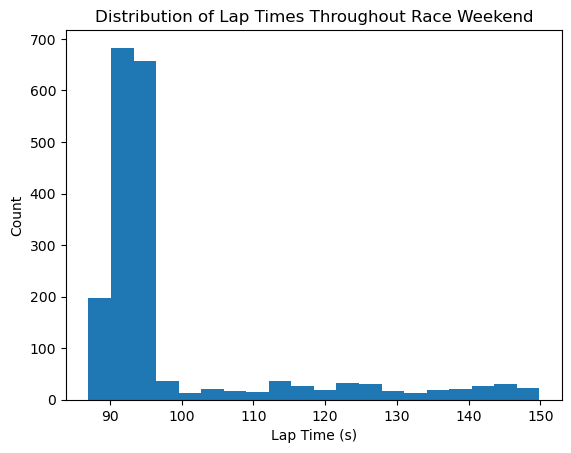

In [13]:
plt.hist(all_laps_raw["LapTime"].dt.total_seconds(), bins = 20)
plt.ylabel("Count")
plt.xlabel("Lap Time (s)")
plt.title("Distribution of Lap Times Throughout Race Weekend")
plt.show()

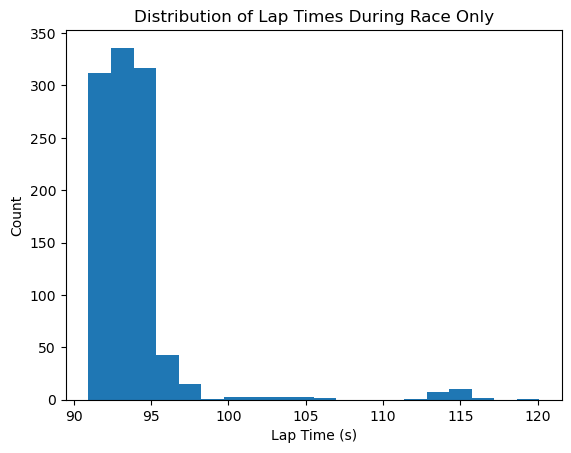

In [14]:
plt.hist(all_laps.loc["Race"]["LapTime"], bins = 20)
plt.ylabel("Count")
plt.xlabel("Lap Time (s)")
plt.title("Distribution of Lap Times During Race Only")
plt.show()

Currently, the race weekend has much more dirty data than the race itself

## Methods and Results
I intend to approach this problem by training a linear model to predict lap times with the specified features. Due to the complex nature of the relationships between some of these attributes, I also intend to use data visualization to determine how and if to transform these features in order to better fit a linear model. Transformations include using polynomial features, natural splines, binning ordinal data, and interactions between some variables. Since the scope of this project is explanatory analytics, I will randomly split the entire set of lap data into training and testing data. Further investigation could use free practice data and data from previous events to train a model to predict the outcome of a future race, but we will avoid doing so in this project to maintain a reasonable scope.
**(Note: splitting entire dataset is subject to change later in project, also maybe move comment on predicting outcomes to discussion)**

In [15]:
# sklearn workflow
hot_column_selector = make_column_selector(dtype_include = ["bool", "object"])  # Selects all columns that need to be run through OneHotEncoder, ie booleans and strings (objects)
boolean_converter = make_column_transformer([OneHotEncoder(drop = "first"), hot_column_selector], remainder = "passthrough")

#steps = boolean_converter, LinearRegression()  # make_pipeline(steps) Doesn't work, gets passed as list or tuple
basic_pipeline = make_pipeline(boolean_converter, LinearRegression())

In [16]:
# Fit model with train_test split
X = all_laps.drop(columns = ["LapTime"])  # Try taking out driver for test, filtering better for slow laps
y = all_laps.LapTime

X_train, X_test, y_train, y_test = train_test_split(X, y)

test_fit2 = basic_pipeline.fit(X_train, y_train)

In [17]:
test_fit2.score(X_test, y_test)

0.25515007881946417

In [19]:
pd.Series(data = test_fit2[-1].coef_, index = test_fit2[:-1].get_feature_names_out())

onehotencoder__Driver_ALO          -0.383882
onehotencoder__Driver_ANT          -1.371638
onehotencoder__Driver_BEA          -3.984348
onehotencoder__Driver_BOR          -1.802473
onehotencoder__Driver_DOO          -1.546889
onehotencoder__Driver_GAS           1.199614
onehotencoder__Driver_HAD          -0.749016
onehotencoder__Driver_HAM          -2.350611
onehotencoder__Driver_HIR          -1.150779
onehotencoder__Driver_HUL          -2.596668
onehotencoder__Driver_LAW          -2.137746
onehotencoder__Driver_LEC          -0.397600
onehotencoder__Driver_NOR          -2.720664
onehotencoder__Driver_OCO          -2.661686
onehotencoder__Driver_PIA          -2.421348
onehotencoder__Driver_RUS          -2.923452
onehotencoder__Driver_SAI           0.424953
onehotencoder__Driver_STR           2.881127
onehotencoder__Driver_TSU          -2.566772
onehotencoder__Driver_VER          -3.957652
onehotencoder__Compound_MEDIUM     -0.605202
onehotencoder__Compound_SOFT        0.780244
onehotenco

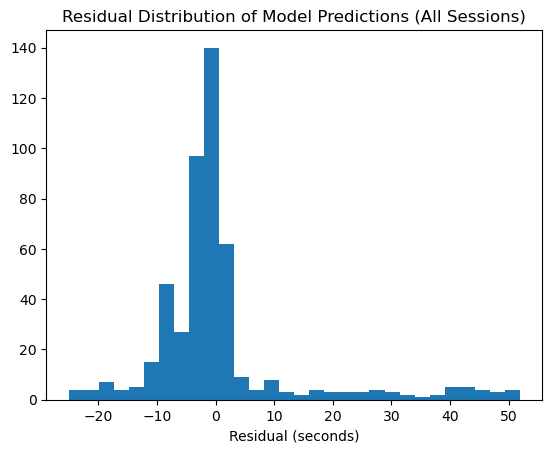

In [20]:
test_residuals = y_test - test_fit2.predict(X_test)
plt.hist(test_residuals, bins = 30)
plt.title("Residual Distribution of Model Predictions (All Sessions)")
plt.xlabel("Residual (seconds)")
plt.show()

In [21]:
# Fit model with train_test split on only race data
race_subset = all_laps.loc["Race"]
X = race_subset.drop(columns = ["LapTime"])
y = race_subset.LapTime

X_train, X_test, y_train, y_test = train_test_split(X, y)

test_fit = basic_pipeline.fit(X_train, y_train)

In [22]:
test_fit.score(X_test, y_test)  # Surely has to be overfitting

0.926096454725801

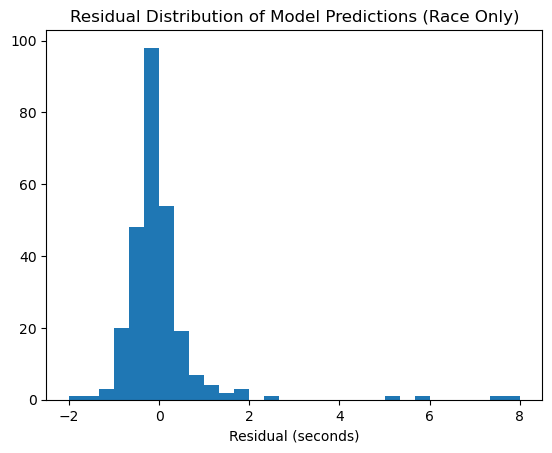

In [23]:
test_residuals = y_test - test_fit.predict(X_test)
plt.hist(test_residuals, bins = 30)
plt.title("Residual Distribution of Model Predictions (Race Only)")
plt.xlabel("Residual (seconds)")
plt.show()

The model seems to have normally distributed residuals, with the exception of the outliers where the model greatly underestimates the lap time. Given that there are 4 of these outliers, they could likely be attributed to things like going off track or a botched pitstop, which are things we cannot reasonably predict. <br>
A determination coefficient this high indciates that there is some overfitting or data leaking, which we will explore later. <br>
Testing for discrepancy between all sessions and race only notes: tried lap number (thinking about refueling), didn't help. Next idea: Discrepancy in "pit stop" length between practice/quali and race

In [24]:
pd.Series(data = test_fit[-1].coef_, index = test_fit[:-1].get_feature_names_out()).sort_values()  # Encoder dropped Albon
# Idea for future: train pit entered/pit exited times on races in past years, 
# see if those predictions match the ones we get by modeling this years race data.
# If the predictions are similar, we can mutate race predicted race laps to include this offset and 
# get closer to being able to predict races using only practice/quali data

onehotencoder__Driver_VER          -0.777034
onehotencoder__Driver_NOR          -0.751528
onehotencoder__Driver_PIA          -0.730643
onehotencoder__Driver_LEC          -0.462004
onehotencoder__Driver_RUS          -0.433564
onehotencoder__Driver_ANT          -0.361689
onehotencoder__Driver_HAM          -0.249749
remainder__LapNumber               -0.088237
onehotencoder__Compound_MEDIUM     -0.060563
onehotencoder__Driver_HAD          -0.030403
remainder__TyreLife                 0.025854
onehotencoder__Driver_BEA           0.171766
onehotencoder__Driver_TSU           0.234130
onehotencoder__Driver_ALO           0.323557
onehotencoder__Compound_SOFT        0.358021
onehotencoder__Driver_GAS           0.481515
onehotencoder__Driver_SAI           0.535167
onehotencoder__Driver_DOO           0.639166
onehotencoder__Driver_HUL           0.666510
onehotencoder__Driver_OCO           0.782552
onehotencoder__Driver_LAW           0.815177
onehotencoder__Driver_STR           0.881184
onehotenco

Strangely enough, regardless of training data, this data seems to imply that soft tires result in slower lap times, which contradicts intuition. We will need to further investigate the context in which they were used (it is possible that there is some confounding factor) in order to understand why this is happening. I originally hypothesized that this could be because of the lesser representation in race data, but this is most likely not the case since the same result shows when training on the entire race weekend. <br>
As for how the model weighs drivers, it does an okay job ordering drivers. If we compare ranking by weight to race results, it gets many things right, such as Verstappen being fastest, Stroll being slowest, Russel and Antonelli being in the correct order, etc. However, there are some strange artifacts, such as Bearman supposedly having the second fastest average pace, despite finishing in 10th. It is possible that due to complex factors these factors are not comparable.

In [25]:
# Testing how much effect dropping each feature has on coefficient of determination
dropped_cols_set = [["Driver"], ["Compound"], ["EnteredPits", "ExitedPits"], ["LapNumber"], ["TyreLife"], ["Driver", "Compound", "LapNumber", "TyreLife"]]
for dropped_cols in dropped_cols_set:
    race_subset = all_laps.loc["Race"].drop(columns = dropped_cols)
    X = race_subset.drop(columns = ["LapTime"])
    y = race_subset.LapTime

    X_train, X_test, y_train, y_test = train_test_split(X, y)

    test_fit = basic_pipeline.fit(X_train, y_train)
    print(f"Without {dropped_cols}: {test_fit.score(X_test, y_test)}")

Without ['Driver']: 0.8777564083598068
Without ['Compound']: 0.8371465185579442
Without ['EnteredPits', 'ExitedPits']: 0.14812724125873045
Without ['LapNumber']: 0.7957774903190797
Without ['TyreLife']: 0.8274254299009569
Without ['Driver', 'Compound', 'LapNumber', 'TyreLife']: 0.8294852466747071


Based on this preliminary swapping out of features, it seems that removing whether a vehicle entered or exited from the pits has the greatest effect on accuracy (which makes sense since out of all these features, making a pit stop affects times the most). In fact, a model trained solely on whether a vehicle entered or exited the pits has a coefficient of determination of approximately 0.6, which if anything shows how tightly grouped lap times are.

## Discussion
Overall, the results of this project make for an acceptable start for future work. While the model trained on the entire race weekend exhibits poor performance, that can be attributed to insufficient cleaning, demonstrated by the distribution of lap time graphs. The linear model trained on race data seems to maintain a strong degree of accuracy with no evidence of overfitting or target data leaking. <br>
From these results, it is clear that tracking the number of laps completed (or a feature correlated to it), tire life, and pit entry/exit is vital for a successful model. Other features such as driver and tire compound are less clear in terms of contribution, but this can be resolved with more rigorous statistical analysis. <br>
The next steps for this project are to improve cleaning methods for race weekend data, then to investigate the possibility of developing a model that can predict race lap times using only data from previous sessions. This project has demonstrated that such a linear model is suitable for the next steps of development, along with what steps must be taken to ensure cleanliness of lap data.